# 渲染三维物体

## 顶点与面

在一个三维空间中，一个物体可以由多个顶点组成的多个面构成，为了简化问题一个面最少可以由三个顶点构成，所以计算机中通常使用三角形来表示一个面。

In [30]:
octahedron = [
    [(1, 0, 0), (0, 1, 0), (0, 0, 1)],
    [(1, 0, 0), (0, 0, -1), (0, 1, 0)],
    [(1, 0, 0), (0, 0, 1), (0, -1, 0)],
    [(1, 0, 0), (0, -1, 0), (0, 0, -1)],
    [(-1, 0, 0), (0, 0, 1), (0, 1, 0)],
    [(-1, 0, 0), (0, 1, 0), (0, 0, -1)],
    [(-1, 0, 0), (0, -1, 0), (0, 0, 1)],
    [(-1, 0, 0), (0, 0, -1), (0, -1, 0)],
]

上面的代码定义了一个八面体，每个面由三个顶点构成，每个顶点是一个三维向量。

可以使用 `draw3d` 函数提供的绘制功能展示此八面体。

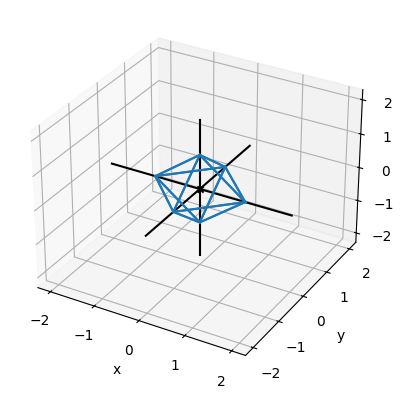

In [31]:
from py_lib.draw3d import Segment3D
from py_lib.draw3d import draw3d

example_lines = []

for face in octahedron:
    example_lines.append(Segment3D(face[0], face[1]))
    example_lines.append(Segment3D(face[1], face[2]))
    example_lines.append(Segment3D(face[2], face[0]))

draw3d(
    *example_lines
)

上面的方法直接使用的是 `draw3d` 函数提供的绘制功能，内部已经对摄像机角度、坐标轴等进行了设置，下面需要通过二维坐标系的方式来绘制三维空间的物体。

## 将三维物体投影到二维平面

将三维物体在二维平面中绘制的关键是将三维物体投影到二维平面，可以将每个线段投影到二维平面上，然后绘制这些线段。

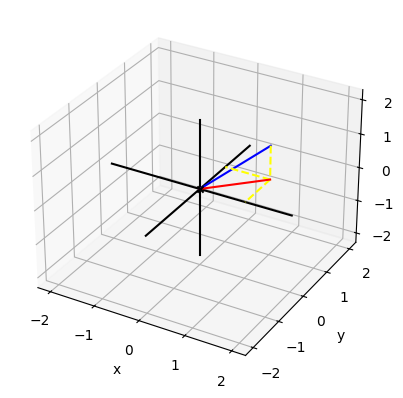

In [32]:
draw3d(
    Segment3D((0, 0, 0), (1, 1, 1), color='blue'),
    Segment3D((1, 1, 1), (1, 1, 0), color='yellow', linestyle='dashed'),
    Segment3D((1, 1, 0), (0, 1, 0), color='yellow', linestyle='dashed'),
    Segment3D((1, 1, 0), (1, 0, 0), color='yellow', linestyle='dashed'),
    Segment3D((0, 0, 0), (1, 1, 0), color='red'),
)

上面的代码绘制了一个从三维空间中的蓝色线段投影到二维平面中红色线段的效果，可以将一个三维物体的所有线段和顶点都投影到二维平面上，然后绘制这些线段和顶点。

In [33]:
import math


def dot(u, v):
    return sum(coord1 * coord2 for coord1, coord2 in zip(u, v))


def length(v):
    return math.sqrt(sum(coord ** 2 for coord in v))


def component(v, direction):
    return dot(v, direction) / length(direction)


def vector_to_2d(v):
    return component(v, (1, 0, 0)), component(v, (0, 1, 0))


In [34]:
print(f'三维向量 (1, 1, 1) 投影到二维平面的坐标为：{vector_to_2d((1, 1, 1))}')
print(f'三维向量 (1, 1, 0) 投影到二维平面的坐标为：{vector_to_2d((1, 1, 0))}')
print(f'三维向量 (3, 4, 10) 投影到二维平面的坐标为：{vector_to_2d((3, 4, 0))}')

三维向量 (1, 1, 1) 投影到二维平面的坐标为：(1.0, 1.0)
三维向量 (1, 1, 0) 投影到二维平面的坐标为：(1.0, 1.0)
三维向量 (3, 4, 10) 投影到二维平面的坐标为：(3.0, 4.0)


In [35]:
def face_to_2d(face):
    return [vector_to_2d(v) for v in face]


octahedron_2d = [face_to_2d(face) for face in octahedron]

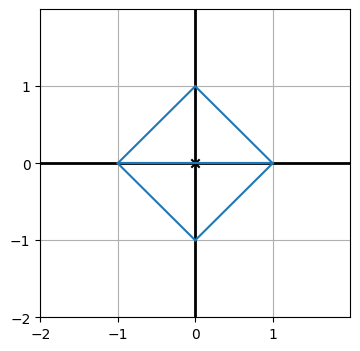

In [36]:
from py_lib.draw2d import draw2d, Segment2D

example_2d_lines = []

for face in octahedron_2d:
    example_2d_lines.append(Segment2D(face[0], face[1]))

draw2d(*example_2d_lines, width=4)

## 三维物体着色

在三维空间的物体中，物体表面会因为光照的不同而产生不同的颜色，可以通过计算物体表面的法向量和光照方向的夹角来确定物体表面的颜色。

可以通过向量的叉积来计算物体表面的法向量，并通过法向和光照两个向量的点积来计算物体表面的光照强度。

In [37]:
from py_lib.vectors import scale, cross, subtract, add


def unit(v):
    return scale(1. / length(v), v)

首先使用 `subtract` 将此面顶点的原点设置为 `face[0]`，然后使用 `cross` 计算出此面的法向量。

In [38]:
def normal(face):
    return cross(subtract(face[1], face[0]), subtract(face[2], face[0]))

添加一个 `render` 函数，用于渲染三维物体，流程如下：

1. 获取一个面并计算面的法向量
2. 如果法向量的 $z$ 值大于 $0$，则计算光照方向和法向量的夹角（不计算垂直于当前摄像机方向和另一个方向的面）
3. 计算法向量和光照方向的夹角，计算出光照强度并设置颜色
4. 将这个面添加到渲染列表中

In [39]:
import matplotlib
from py_lib.draw2d import Polygon2D, draw2d

blues = matplotlib.colormaps.get_cmap('Blues')


def render(faces, light=(1, 2, 3), color_map=blues, lines=None):
    polygons = []
    for face in faces:
        unit_normal = unit(normal(face))
        if unit_normal[2] > 0:
            c = color_map(1 - dot(unit(normal(face)), unit(light)))
            p = Polygon2D(*face_to_2d(face), fill=c, color=lines)
            polygons.append(p)
    draw2d(*polygons, width=4)

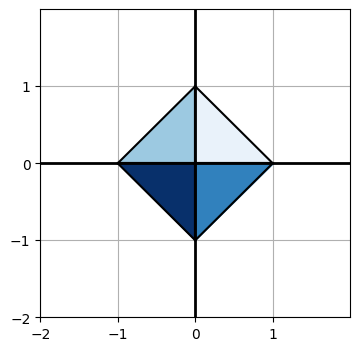

In [40]:
render(octahedron, lines='black')

可以看到，八面体的每个面都有不同的颜色，这是因为每个面的法向量和光照方向的夹角不同，所以颜色也不同。

可以通过递归细化每个面来得到一个更加圆滑的物体，最后可以得到一个近似球体的物体。

In [41]:
def split(face):
    midpoints = [unit(add(face[i], face[(i + 1) % len(face)])) for i in range(0, len(face))]
    triangles = [(face[i], midpoints[i], midpoints[(i - 1) % len(face)]) for i in range(0, len(face))]
    return [midpoints] + triangles


def rec_split(faces, depth=0):
    if depth == 0:
        return faces
    else:
        return rec_split([new_face for face in faces for new_face in split(face)], depth - 1)


# NICE SPHERE!
def sphere_approx(n):
    return rec_split(octahedron, n)

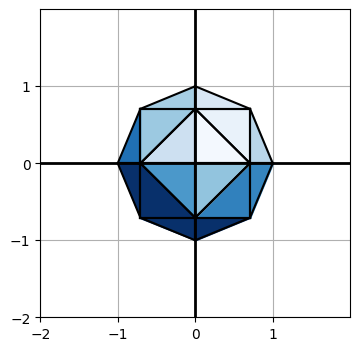

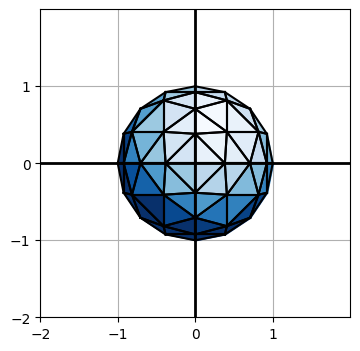

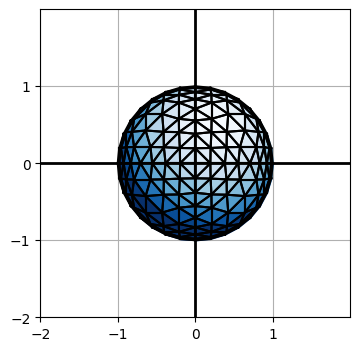

In [43]:
render(sphere_approx(1), lines='black')
render(sphere_approx(2), lines='black')
render(sphere_approx(3), lines='black')